# HCN channels: $I_h$

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/HCN_channels" folder

In [2]:
data_folder = "data/HCN_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/HCN_channels


['data/HCN_channels/2025_06_11_0005.abf',
 'data/HCN_channels/K_deact_1.abf',
 'data/HCN_channels/K_deact_3.abf',
 'data/HCN_channels/K_deact_2.abf']

Choose which file you want to analyze and past the file name here:

In [3]:
data_file = 'data/HCN_channels/2025_06_11_0005.abf'

Now we can load the file and plot the raw data:

Data dimensions (sweeps, channels, timepoints): 
(9, 2, 34000)
sampling freq: 10000.0 Hz


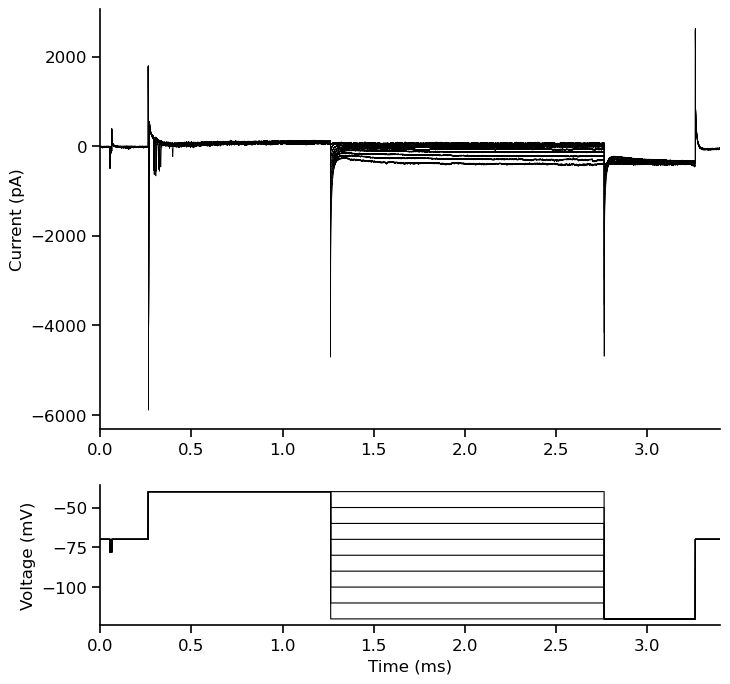

In [48]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(f"Data dimensions (sweeps, channels, timepoints): \n{sweeps.shape}")
print(f"sampling freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
ax = plot_traces(sweeps_time, current_traces, voltage_traces)
# ax[0].set_ylim([-1000,200])
# ax[0].set_xlim([1.1,2.8])
plt.show()

### Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

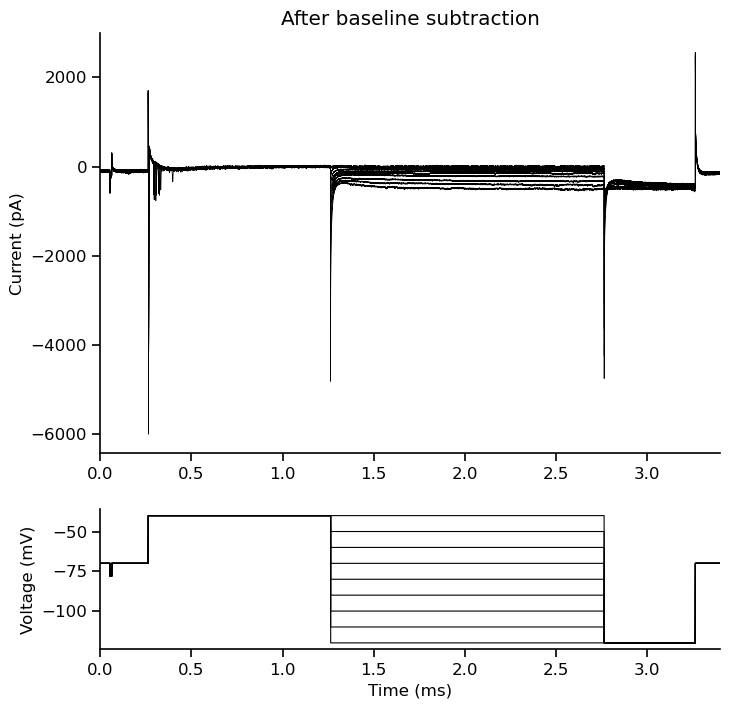

In [43]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

# Measure baseline: you need to specify which part of the trace you want to use for baseline measurement.
start_baseline = 1150 # milliseconds
end_baseline = 1200 # milliseconds
measurement_type = 'mean' # Options: 'mean', 'max', 'min'


# --------------------------------------------------------------------------------------------------------------------
if subtract_baseline:
    baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_baseline, end_baseline, sampling_freq, measurement_type)

    # Subtract baseline from the sweeps
    num_traces = sweeps.shape[0]
    for i in range(num_traces):
        sweeps[i,0] -= baseline_current[i]

    current_traces = sweeps[:, 0, :]
    voltage_traces = sweeps[:, 1, :]
    ax = plot_traces(sweeps_time, current_traces, voltage_traces)    
    ax[0].set_title('After baseline subtraction')
    plt.show()

## 2. Select what you want to measure

(If you want to save images, click on the save icon in the top-right of the image when you hover over it)

### 2.1. Define the time window to measure the IV

First let's define the relevant time window where we want to measure the currents:

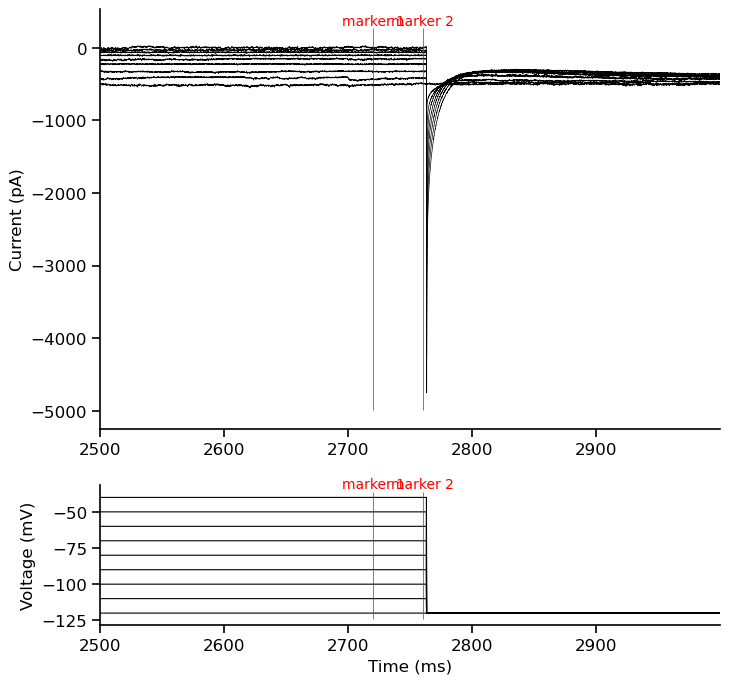

In [44]:
# The start/end time just helps to zoom in on the traces.
start_time = 2500  # milliseconds
end_time = 3000   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 2720  # milliseconds
marker_2 = 2760  # milliseconds

# ----------------------------------------------------------------------------------------------------------------------
current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
ax = plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)
plt.show()

### 2.2. Plot IV curve

Get the average steady-state current in the window and plot against voltage

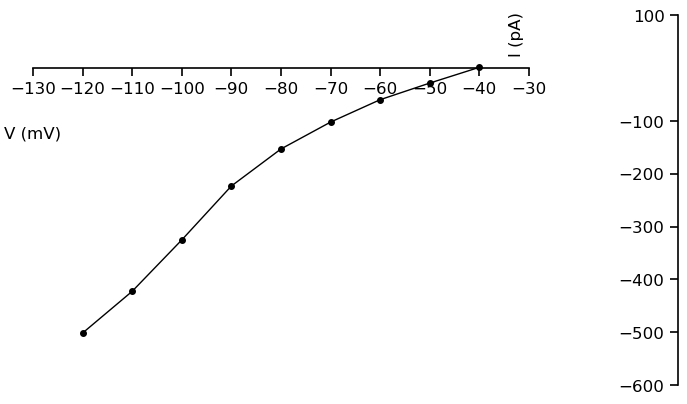

In [45]:
measurement_type = 'mean' # Options: 'mean', 'max', 'min', 'peak'

voltage_steps, current_steps = get_step_measurements(sweeps, sweeps_time, 
                                                     start_time=marker_1,
                                                     end_time=marker_2,
                                                     sampling_freq=sampling_freq,
                                                     measurement_type=measurement_type)
if np.all(voltage_steps == voltage_steps[0]):
    print("WARNING: All voltage steps are the same")
if np.all(current_steps == current_steps[0]):
    print("WARNING: All current steps are the same")
    
ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.,0.7), ylabel_coords=(0.99,0.95))
plt.show()

### 2.3. Measure tail currents to get the channel activation curve

Measure the instantaneous tail currents in the second part of the recording


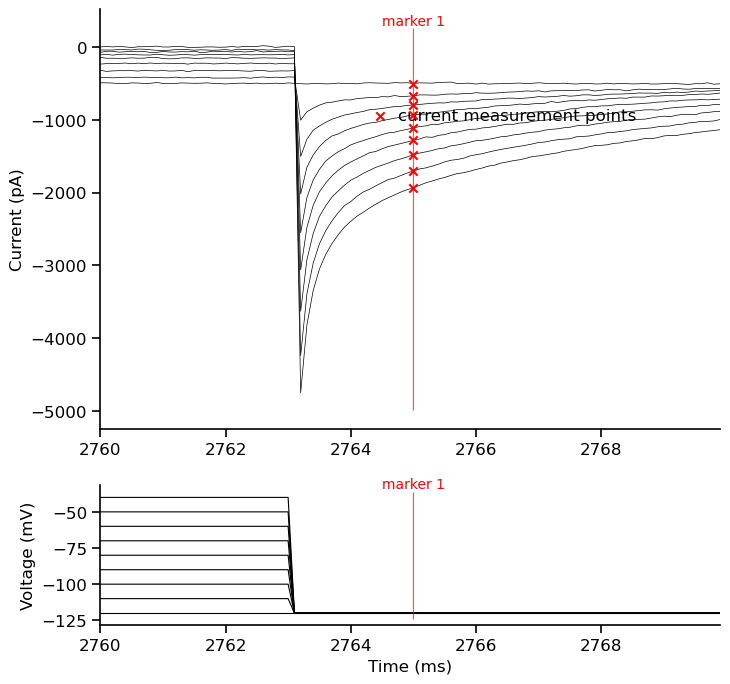

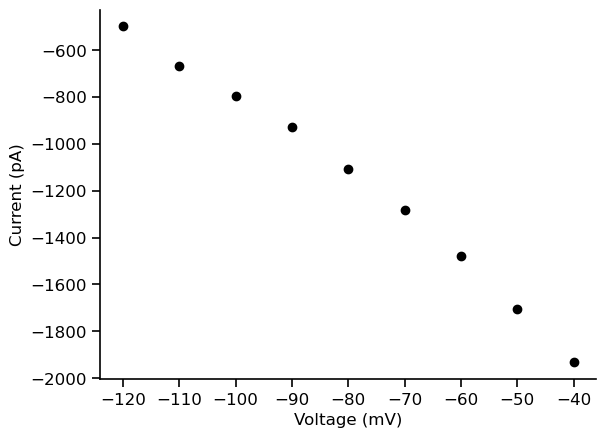

In [ ]:
# The start/end time just helps to zoom in on the traces.
start_time = 2760  # milliseconds
end_time = 2770   # milliseconds, (enter -1 to get the end of the sweep)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker = 2765  # milliseconds


# ----------------------------------------------------------------------------------------------------------------------
current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)
ax = plot_traces(time_in_window, current_traces, voltage_traces, marker)

marker_idx = time_to_index(marker, sampling_freq)
tail_currents = current_at_marker1 = sweeps[:,0,marker_idx]
ax[0].scatter([marker]*len(tail_currents), tail_currents, color='red', marker='x', label="current measurement points", zorder=10)
ax[0].legend(loc='upper left', bbox_to_anchor=(0.4, 0.8))
plt.show()

# Plot the tail currents
plt.plot(voltage_steps, tail_currents, 'o', color='black')
plt.xlabel('Voltage (mV)')
plt.ylabel('Current (pA)')
plt.show()

### 2.4. Fit a Boltzmann curve (sigmoid) to the normalized currents 

We will be fitting this function (Boltzmann equation) to your data points:
$$ \frac{I}{I_{\text{max}}} = I_{norm} = \frac{1}{1 + \exp\left(\frac{V_{\text{half}} - V}{k}\right)}$$

V_half = -126100456.03 mV, k = 742253007.80


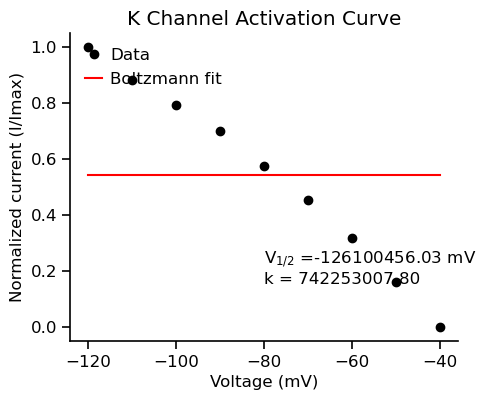

In [47]:
I_min = np.min(tail_currents)
I_max = np.max(tail_currents)
I_norm = (tail_currents - I_min) / (I_max - I_min)

# Fit the Boltzmann function (sigmoidal curve) to the data and overlay
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
k_guess = 5 # Initial guess for the slope parameter to fit the curve
popt, _ = curve_fit(boltzmann, voltage_steps, I_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
I_fit = boltzmann(V_fit, V_half_fit, k_fit)
print(f"V_half = {V_half_fit:.2f} mV, k = {k_fit:.2f}")

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, I_norm, 'o', label='Data', color='black')
ax.plot(V_fit, I_fit, '-', label='Boltzmann fit', color='red')
ax.text(0.5, 0.3, 'V$_{1/2}$ ='+f'{V_half_fit:.2f} mV \nk = {k_fit:.2f}', transform=ax.transAxes, ha='left', va='top')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Normalized current (I/Imax)')
ax.set_title('K Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()